In [1]:
#load libraries and setup file
import sys,os
root_path = os.path.abspath(os.path.join('..'))
print(root_path)
if root_path not in sys.path:
    sys.path.append(root_path)
%run -i "../lib/utils/ipynb_setup.py"
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts


In [3]:
#plotting
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
pl.rc("figure", facecolor="white",figsize = (8,8))
#pl.rc("figure", facecolor="gray",figsize = (8,8))
pl.rc('text', usetex=True)
pl.rc('text.latex', preamble=[r'\usepackage{amsmath}'])
pl.rc('lines',markeredgewidth = 2)
pl.rc('font',size = 12)

In [4]:
from lib.lib import get_trajs,get_pt_plus

In [202]:
import scipy.io as spio
mat = spio.loadmat('../data/toktrials.mat', squeeze_me=True)

In [204]:
df_traj.columns

Index(['idSubject', 'nPostInterval', 'nChoiceMade', 'nCorrectChoice',
       'tDecision', 'tFirstTokJump', 'nDecisionToken', 'nDProb', 'nDSLR',
       'sTokenDirs', 'sTrialType'],
      dtype='object')

In [210]:
col_names=mat['toktrials'].flatten().dtype.names
df_traj=pd.DataFrame(columns=col_names)
for col_name in col_names:
    df_traj[col_name]=mat['toktrials'].flatten()[0][col_name]
df_traj.tDecision=(df_traj.tDecision-df_traj.tFirstTokJump)/200+1 #since first jump at t=1
#-remove samples with null deicsion times 
df_traj=df_traj[~df_traj.tDecision.isnull()]
#-remove hand designed trials 
df_traj=df_traj[~(df_traj.sTrialType.isin(df_traj.sTrialType.unique()[-2:]) & (df_traj.sTrialType.isin(df_traj.sTrialType.unique()[-2:])))]
df_traj.reset_index();
df_traj['seq']=df_traj.sTokenDirs.apply(lambda x:2*(np.asarray([int(el) for el in list(x)])-1)-1) #note indexing starts at t=1, since len=T not T+1
#sTrialType :A string describing the trial type: 
# easy (‘E’), 
# ambiguous (‘A’), 
# misleading (‘M’), 
# bias-for (‘C’ or ‘c’), 
# random (‘x’), or 
# unclassified (‘null’)
df_traj['Nt']=df_traj.seq.apply(lambda x: np.insert(np.cumsum(x),0,0))
df_traj['nCorrectChoice']=(df_traj['Nt'].apply(lambda x:x[-1])>0)
df_traj=df_traj[['Nt','seq','nPostInterval','idSubject','nCorrectChoice']]

# df_traj=get_trajs()
# df_traj.head()

In [211]:
df_traj.head()

,Nt,seq,nPostInterval,idSubject,nCorrectChoice
0,"[0, -1, -2, -1, 0, -1, -2, -1, -2, -1, 0, -1, ...","[-1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, ...",50,1,True
1,"[0, 1, 2, 1, 0, -1, -2, -3, -4, -3, -4, -3, -2...","[1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1...",50,1,False
2,"[0, -1, -2, -1, 0, -1, 0, 1, 0, 1, 0, 1, 2, 1,...","[-1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, ...",50,1,True
3,"[0, 1, 2, 1, 2, 3, 4, 5, 6, 5, 6, 7, 8, 7, 8, 7]","[1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1]",50,1,True
4,"[0, 1, 2, 3, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1]","[1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, ...",50,1,True


In [214]:
# def dummy(row):
#     return np.array([get_pt_plus(t,Nt) for t,Nt in enumerate(row)])
# df_traj['Pt_plus']=df_traj.Nt.apply(lambda x: dummy(x))
# # df_traj['evidence']=df_traj.Pt_plus.apply(lambda x: np.log(x/(1-x)))
# df_traj['plus']=(df_traj['Nt'].apply(lambda x:x[-1])>0)
def dummy(Nt_seq):
    return np.array([(get_pt_plus(t,Nt) if Nt>=0 else 1-get_pt_plus(t,Nt)) for t,Nt in enumerate(Nt_seq)])
df_traj['p_suc_seq']=df_traj.Nt.apply(lambda x: dummy(x))

In [7]:
#check these are consistent with dyn_prog_model.npy
para=dict()
para['T']=15
para['T_ITI']=8#para['T']/2=7.5 in primate experiments set to 8 so that all trial durations are integers
para['p']=1/2
para['tp']=0
alp_slow=1/4
alp_fast=3/4

In [8]:
from lib.dyn_prog_model import get_reward_rate_for_varybound

In [9]:
def get_linfall_RR(dfb,alpha,slope,baseline):
    tb=np.arange(para['T']+1,dtype=int)
    bel_boundary=(tb,1-(slope*tb+baseline))
    return get_reward_rate_for_varybound(bel_boundary,dfb,1-alpha,T=para['T'],T_ITI=para['T_ITI'],output_all=True)

In [11]:
dfb=df_traj.copy()

## Test single alpha self-consistency

In [38]:
alpha=alp_fast
RR_store_linfall=[]
cost_rate_vec=np.linspace(0.,0.06,50)
for c in cost_rate_vec:
    RR,T=get_linfall_RR(dfb,alpha,c,0)
    RR_store_linfall.append(RR)
avg_rho=RR_store_linfall[np.argmin(np.fabs(RR_store_linfall-cost_rate_vec))]
print(avg_rho)

0.04704556241101092


No handles with labels found to put in legend.


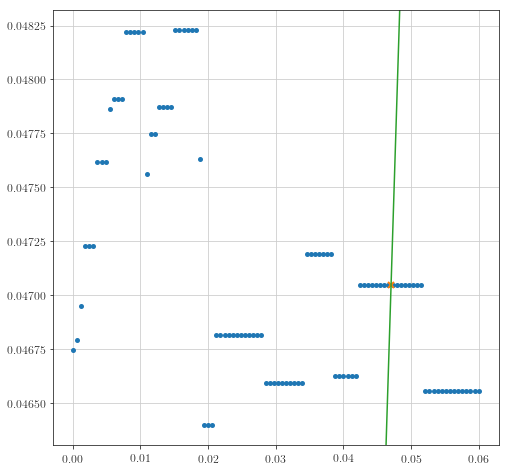

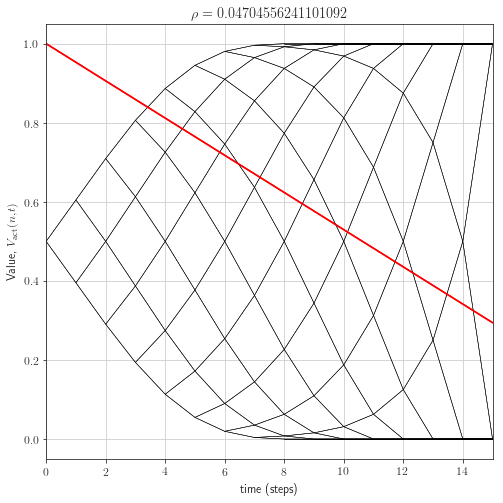

In [39]:
fig,ax=pl.subplots()
ax.plot(cost_rate_vec,RR_store_linfall,'.')
ax.plot([avg_rho],[avg_rho],'x')
ylim=ax.get_ylim()
ax.plot([0,0.06],[0,0.06])
ax.set_ylim(ylim)

fig,ax=pl.subplots()
for alpha in (0.25,0.75):
    for Nm in 2*np.arange(para['T']):
        ax.plot(np.arange(para['T']+1-Nm/2)+Nm/2,[get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Nm/2)+Nm/2,np.arange(para['T']+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.]*3,mew=0.5,mfc='k',mec='k')
    for Np in 2*np.arange(para['T']):
        ax.plot(np.arange(para['T']+1-Np/2)+Np/2,[1-get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Np/2)+Np/2,np.arange(para['T']+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.]*3,mew=0.5,mfc='k',mec='k')
    ax.plot(np.arange(para['T']+1),1-avg_rho*np.arange(para['T']+1),'r')
        # ax.set_ylim(-0.5,1.5)
ax.set_xlim(0,para['T'])
ax.set_ylabel(r'Value, $V_{\textrm{act}}(n,t)$')
ax.set_xlabel(r'time (steps)')
ax.set_title(r'$\rho='+str(avg_rho)+'$')
ax.legend(frameon=False)

## Test single alpha self-consistency iterated

In [29]:
dfb=df_traj.copy()
alpha=alp_fast
RR_store_linfall=[]
tol=1e-16
RR=0
diff=np.Inf
while diff>tol:
    print(RR)
    RR_store_linfall.append(RR)
    RRold=deepcopy(RR)
    RR,T=get_linfall_RR(dfb,alpha,RR,0)
    diff=np.fabs(RR-RRold)

0
0.04674331688111609
0.04704556241101092


(0.045, 0.048)

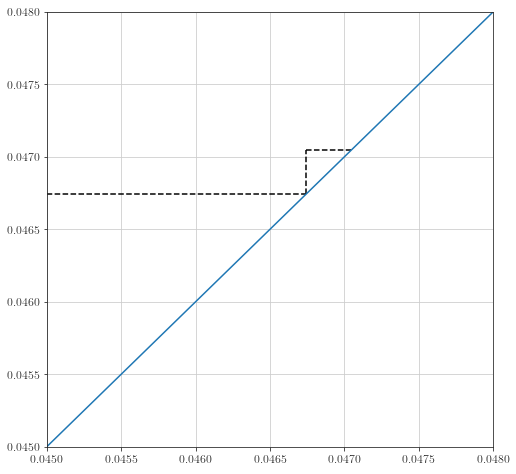

In [28]:
fig,ax=pl.subplots()
for it,RR in enumerate(RR_store_linfall[:-1]):
    ax.plot([RR,RR],[RR,RR_store_linfall[it+1]],'k--')
    ax.plot([RR,RR_store_linfall[it+1]],[RR_store_linfall[it+1],RR_store_linfall[it+1]],'k--')
# ylim=ax.get_ylim()
ax.plot([0,0.06],[0,0.06])
# ax.set_ylim(ylim)
ax.set_ylim(0.045,0.048)
ax.set_xlim(0.045,0.048)

## over alpha

In [13]:
alpvec=np.linspace(0,1,11)
rho_store=[]
T_store=[]
RR_store_traj=[]
st=time.time()
for alpha in alpvec:
    tol=1e-16
    RR=0
    T=0
    RR_store_linfall=[RR]
    T_store_linfall=[T]
    diff=np.Inf
#     while diff>tol:
    for it in range(6):    
        RRold=deepcopy(RR)
        RR,T=get_linfall_RR(dfb,alpha,RR,0)
        T_store_linfall.append(T)
        RR_store_linfall.append(RR)
        diff=np.fabs(RR-RRold)
    RR_store_traj.append(RR_store_linfall)
    rho_store.append(RR)
    T_store.append(T)
print(time.time()-st)

TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'

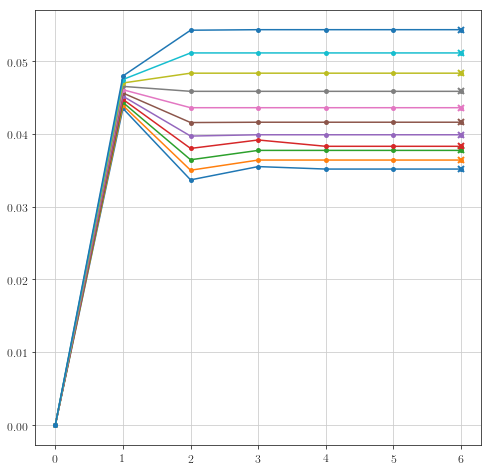

In [15]:
fig,ax=pl.subplots()
for ait,alp in enumerate(alpvec):
    p=ax.plot(RR_store_traj[ait],'.-')
    ax.plot([len(RR_store_traj[ait])-1],[RR_store_traj[ait][-1]],'x',color=p[-1].get_color())

(-0.002714932126696833, 0.05701357466063348)

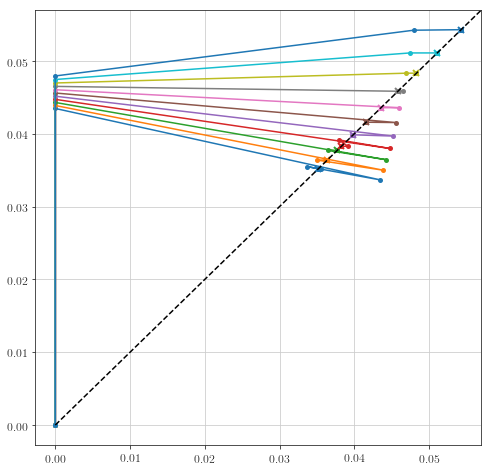

In [16]:
fig,ax=pl.subplots()
for ait,alp in enumerate(alpvec):
    p=ax.plot(np.insert(RR_store_traj[ait][:-1],0,0),np.insert(RR_store_traj[ait][1:],0,0),'.-')
    ax.plot([RR_store_traj[ait][-2]],[RR_store_traj[ait][-1]],'x',color=p[-1].get_color())
ylim=ax.get_ylim()
xlim=ax.get_xlim()
ax.plot([0,0.06],[0,0.06],'k--')
ax.set_ylim(ylim)
ax.set_xlim(xlim)
# ax.set_ylim(0,0.07)

(-0.002714932126696833, 0.05701357466063348)

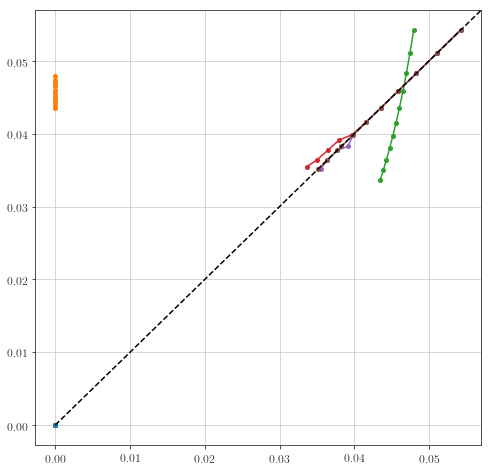

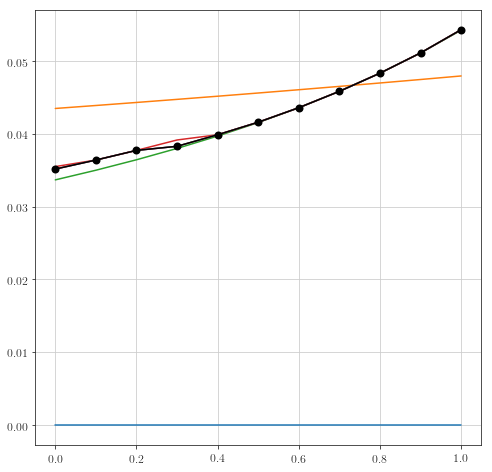

In [20]:
fig,ax=pl.subplots()
fig2,ax2=pl.subplots()
dataold=np.zeros(len(alpvec))
for it in range(6):
    data=[]
    for ait in range(len(alpvec)):
        if len(RR_store_traj[ait])>it:
            data.append(RR_store_traj[ait][it])
    ax.plot(dataold,data,'.-')
    ax2.plot(alpvec,data,'-')
    dataold=data
ax2.plot(alpvec,data,'ko-')
ylim=ax.get_ylim()
xlim=ax.get_xlim()
ax.plot([0,0.06],[0,0.06],'k--')
ax.set_ylim(ylim)
ax.set_xlim(xlim)
# ax.set_ylim(0,0.07)

In [21]:
data

[0.03515625,
 0.0363936847287176,
 0.03772140826590859,
 0.03828130940612882,
 0.03986676433322775,
 0.04158921933085502,
 0.04358292296869503,
 0.045831792121324204,
 0.048325370514820595,
 0.051105898123324396,
 0.05429864253393665]

In [88]:
rho_store=[]
T_store=[]
for alpha in [alp_slow,alp_fast]:
    RR=0
    for it in range(6):    
        RRold=deepcopy(RR)
        RR,T=get_linfall_RR(dfb,alpha,RR,0)
    rho_store.append(RR)
    T_store.append(T)

In [72]:
avg_rho=(T_store[0]*rho_store[0]+T_store[1]*rho_store[1])/(T_store[0]+T_store[1])
print(avg_rho)

0.041718864182064934


# fast slow mixture

In [90]:
RR=0
RR_slow=0
RR_fast=0
T=0
T_slow=0
T_fast=0
RR_store_linfall=[RR]
RR_store_fast=[RR]
RR_store_slow=[RR]
T_store_linfall=[T]
for it in range(10):    
    RRold=deepcopy(RR)

    RR_slow,T_slow=get_linfall_RR(dfb,alp_slow,RR,(RR_slow-RR)*T_slow)
    RR_fast,T_fast=get_linfall_RR(dfb,alp_fast,RR,(RR_fast-RR)*T_fast)
    RR=(T_slow*RR_slow+T_fast*RR_fast)/(T_fast+T_slow)
    T_store_linfall.append((T_slow+T_fast)/2)
    RR_store_linfall.append(RR)
    RR_store_fast.append(RR_fast)
    RR_store_slow.append(RR_slow)

0.04227819866430853


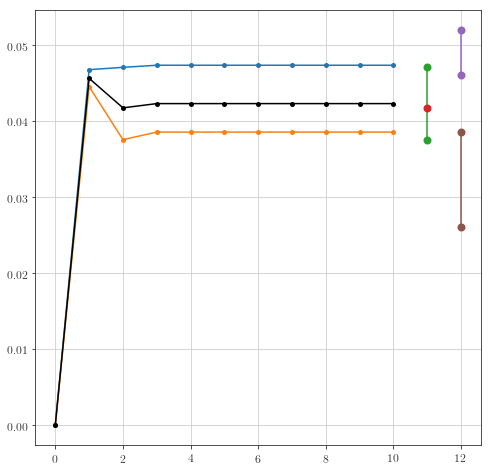

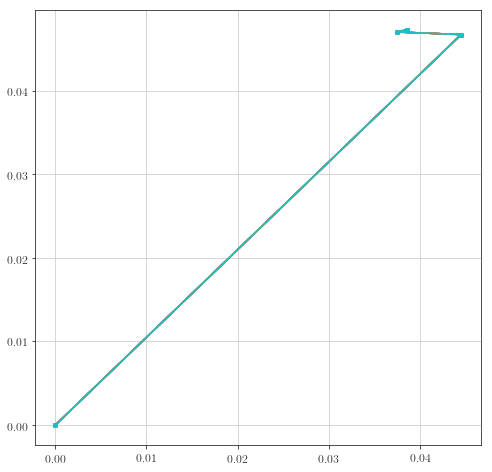

In [93]:
fig,ax=pl.subplots()
ax.plot(RR_store_fast,'.-')
ax.plot(RR_store_slow,'.-')
ax.plot(RR_store_linfall,'k.-')
ax.plot([11,11],rho_store,'o-')
ax.plot([11],avg_rho,'o')
ax.plot([12,12],[0.046,0.052],'o-')
ax.plot([12,12],[0.026,0.0385],'o-')

fig,ax=pl.subplots()
for it in range(10):
    ax.plot(RR_store_slow,RR_store_fast,'.-')

# ylim=ax.get_ylim()
# xlim=ax.get_xlim()
# ax.plot([0,0.06],[0,0.06],'k--')
# ax.set_ylim(ylim)
# ax.set_xlim(xlim)
print(RR_store_linfall[-1])

## Look at behavioural strategies

In [10]:
from lib.plotting import plot_nocost_dec_times

/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/lib/plotting.py:56: RuntimeWarning: invalid value encountered in true_divide
  dec_dist=np.where(occupancy_predec_counts>0,dec_counts/occupancy_predec_counts,0)
/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/lib/plotting.py:56: RuntimeWarning: invalid value encountered in true_divide
  dec_dist=np.where(occupancy_predec_counts>0,dec_counts/occupancy_predec_counts,0)


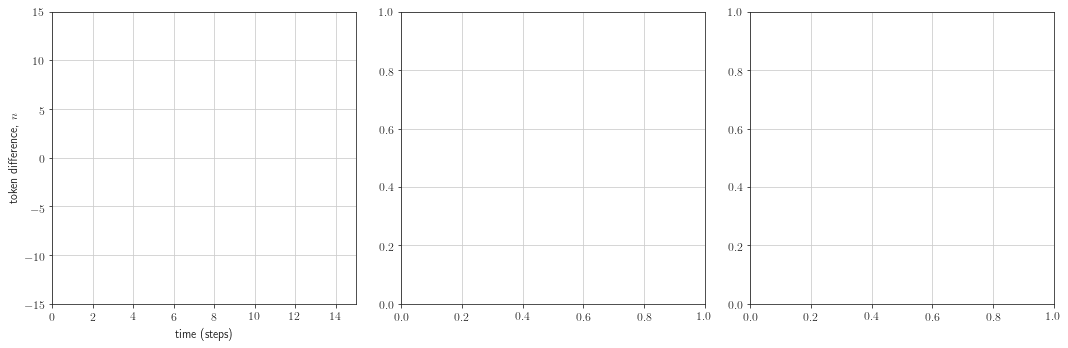

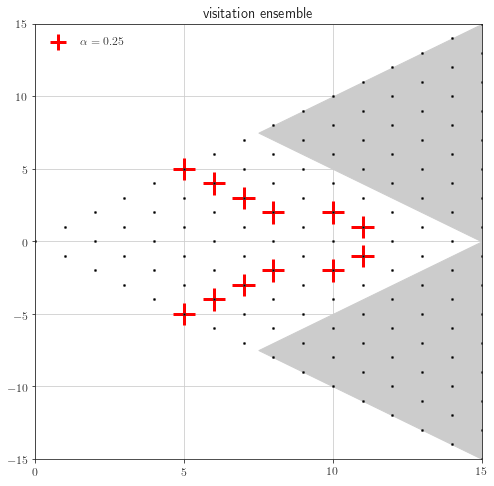

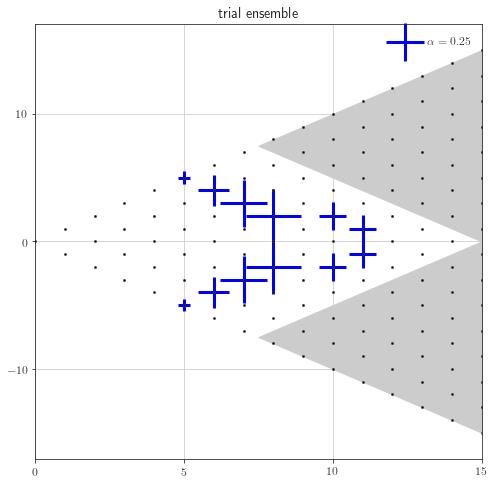

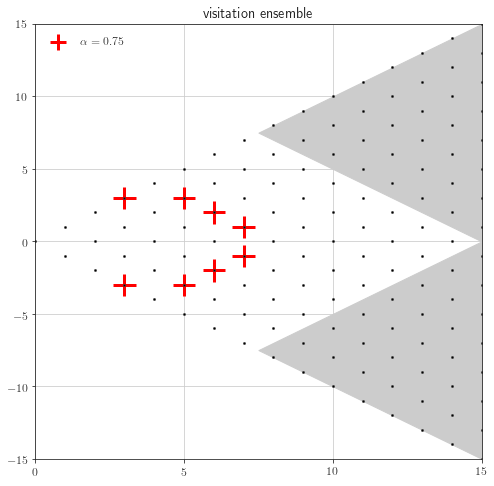

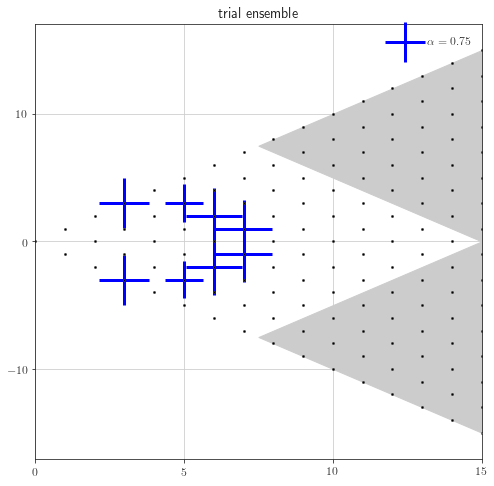

In [98]:
fig,ax=pl.subplots(1,3,figsize=(15,5))
RR=RR_store_linfall[-1]
RR_slow=RR_store_slow[-1]
RR_fast=RR_store_fast[-1]
alpvec=[0.25,0.75]
rhovec=[]
bias_index_vec=[]
avgtdec=[]
blvec=[(RR_slow-RR)*T_slow,(RR_fast-RR)*T_fast]
for it,alp in enumerate(alpvec):
#     rho_zero,data_boundary,dec_data,cost_seq=get_DP_boundary(np.zeros(para['T']+1),1-alp)
#     rhovec.append(rho_zero)
    
    tb=np.arange(para['T']+1,dtype=int)
    
    b_bel=1-(RR*tb+blvec[it])
    b_beltmp=[]
    for t in range(para['T']+1):
        teff=t-(para['T']-len(b_bel))-1
        b_beltmp.append(b_bel[teff] if teff>=0 else 1)
    b_beltmp=np.asarray(b_beltmp)
    dfb=df_traj.copy()
   
    dfb['tDecision']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])

    dfb['nCorrectChoice']=dfb.Nt.apply(lambda x: np.sign(x[-1]))
    dfb['nChoiceMade']=dfb.apply(lambda row: row.Nt[row.tDecision]>0,axis=1)

    avgtdec.append(dfb['tDecision'].mean())
    fig2,ax2=pl.subplots()
    figbase,axbase=pl.subplots()
    bias_index=plot_nocost_dec_times(dfb,pl,'no_cost_alp'+str(alp),axbase,ax2,label_str=r"$\alpha="+str(alp)+r"$")
    bias_index_vec.append(bias_index)
    
    
#     ax[2].plot(cost_seq,'o-',label=r'$\alpha='+str(alp)+'$')#',$'+str(i)+'$')
#     ax[1].plot(*data_boundary[1],'o-',label=r'$\alpha='+str(alp)+'$')#',M$'+str(i)+'$')
    #decision boundary in evidence space
#     tb,b_evi=data_boundary[0]
#     ax[0].plot(tb,b_evi,'.-')

# ax[2].set_ylabel('cost')
# ax[2].set_xlabel('time (step)')

# for Nm in 2*np.arange(para['T']):
#     ax[1].plot(np.arange(para['T']+1-Nm/2)+Nm/2,[get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Nm/2)+Nm/2,np.arange(para['T']+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
# for Np in 2*np.arange(para['T']):
#     ax[1].plot(np.arange(para['T']+1-Np/2)+Np/2,[1-get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Np/2)+Np/2,np.arange(para['T']+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
# ax[1].set_ylim(0,1)
# ax[1].set_xlim(0,para['T'])
# ax[1].set_ylabel(r'Accuracy, $p_{\textrm{corr}}(n,t)$')
# ax[1].set_xlabel(r'time (steps)')
# ax[1].set_title(r'$\rho='+str(print(rho_zero))+'$')
# ax[1].legend(frameon=False)

# state_space=-np.inf*np.ones((para['T']+1,2*para['T']+1))
# for t in range(para['T']+1):
#     state_space[t,slice(para['T']-t,para['T']+1+t,2)]=0.8
# ax[0].imshow(state_space.T,origin='lower',cmap='gray',extent=[-0.5,15.5,-15.5,15.5],vmin=0,vmax=1,aspect='auto',)#'none', 'nearest', 'bilinear', 'bicubic',


ax[0].set_xlim(0,15)
    
ax[0].set_ylim(-para['T'],para['T'])
ax[0].set_xlim(0,para['T'])
ax[0].set_ylabel(r'token difference, $n$')
ax[0].set_xlabel(r'time (steps)')
fig.tight_layout()
# fig.savefig('inferred_zero_costs.pdf', transparent=True,dpi=300)

## Online learning

code to sample trial type sequence then fill in and filter reward rate sequence for optimal strategy:

In [ ]:
def sample_MC_traj(p_0_to_1,p_1_to_0,steps=int(1e4)):
    '''
    create binary symmetric markov state sequence given the two switching rates
    '''
    transition_matrix=np.asarray([[1-p_0_to_1,p_1_to_0],[p_0_to_1,1-p_1_to_0]])
    state_idx=[0,1]
    init_state=0
    current_state = init_state
    state_seq = []
    i = 0
    while i != steps:
        state_seq.append(current_state)
        if current_state==0:
            current_state=np.random.choice(state_idx,p=transition_matrix[0])
        else:
            current_state=np.random.choice(state_idx,p=transition_matrix[1])
        i+=1
    return np.asarray(state_seq)

In [ ]:
alpha2_vec=np.asarray([0.25,0.75])
RR2_Store=np.zeros((2,))
tdec2_Store=np.zeros((2,))
dfb_low=df_traj.copy()
dfb_high=df_traj.copy()
for it,alp in enumerate(alpha2_vec):
    rho_zero,data_boundary,dec_data,cost_seq=get_DP_boundary(np.zeros(para['T']+1),1-alp)
    RR2_Store[it]=rho_zero
    
    tb,b_bel=data_boundary[1]
    b_beltmp=[]
    for t in range(para['T']+1):
        teff=t-(para['T']-len(b_bel))-1
        b_beltmp.append(b_bel[teff] if teff>=0 else 1)
    b_beltmp=np.asarray(b_beltmp)
    if it==0:
        dfb_low['tdec']=dfb_low.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])
        tdec2_Store[it]=dfb_low['tdec'].mean()
        dfb_low['p_tdec']=dfb_low.apply(lambda row:np.max([row.Pt_plus[int(row.tdec)],1-row.Pt_plus[int(row.tdec)]]),axis=1) 
        dfb_low['localRR']=dfb_low.p_tdec/(dfb_low.tdec+(1-alp)*(para['T']-dfb_low.tdec)+para['T_ITI'])
        dfb_low['corr']=dfb_low.Nt.apply(lambda x: np.sign(x[-1]))==dfb_low.apply(lambda row: row.Nt[row.tdec]>0,axis=1)
        dfb_low['Trial']=dfb_low.tdec+(1-alp)*(para['T']-dfb_low.tdec)+para['T_ITI']
    else:
        dfb_high['tdec']=dfb_high.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])
        tdec2_Store[it]=dfb_high['tdec'].mean()
        dfb_high['p_tdec']=dfb_high.apply(lambda row:np.max([row.Pt_plus[int(row.tdec)],1-row.Pt_plus[int(row.tdec)]]),axis=1) 
        dfb_high['localRR']=dfb_high.p_tdec/(dfb_high.tdec+(1-alp)*(para['T']-dfb_high.tdec)+para['T_ITI'])
        dfb_high['corr']=dfb_high.Nt.apply(lambda x: np.sign(x[-1]))==dfb_high.apply(lambda row: row.Nt[row.tdec]>0,axis=1)
        dfb_high['Trial']=dfb_high.tdec+(1-alp)*(para['T']-dfb_high.tdec)+para['T_ITI']

In [ ]:
p_0_to_1=0.005
p_1_to_0=0.005
steps=int(1e6)

iters=1 #trajectory realizations
zetavec=np.power(10,range(2,int(np.log10(steps)))).astype('int') #filtering time constant parameter value set 

density_data=[]
sample_data_store=[]
for it in range(iters):
    state_seq=sample_MC_traj(p_0_to_1,p_1_to_0,steps)
    num_fast=np.sum(state_seq)
    num_slow=len(state_seq)-np.sum(state_seq)
    for zit,zeta in enumerate(zetavec):
        #randomly slot in trials and assign trial sequence index, first for slow block then for fast block
        df_tmp=dfb_low.sample(n=num_slow,replace=True).set_index(np.where(state_seq==0)[0]).append(dfb_high.sample(n=num_fast,replace=True).set_index(np.where(state_seq==1)[0])).sort_index()
#         sample_data=pd.Series(np.repeat(df_tmp.localRR.values,df_tmp.Trial.values.astype('int'))).rolling(zeta).mean()
        sample_data=pd.Series(np.repeat(df_tmp.localRR.values,df_tmp.Trial.values.astype('int'))) #generate reward rate series over time steps from trial index sequence
#         sample_data[0]=sample_data[0]/(1+zeta)
        sample_data=sample_data.ewm(alpha=1/(1+zeta),adjust=True).mean()
        if it==0:
            sample_data_store.append(sample_data[:100000])
        counts,bins=np.histogram(sample_data.values,np.linspace(0.044,0.06,100),density=True)
        density_data.append({"counts":counts,"bins":bins})
       

In [ ]:
fig,ax=pl.subplots(1,2,figsize=(12,4))
colorsre = pl.cm.inferno(np.linspace(0, 0.7, len(zetavec)))
for it in range(iters):
    for zit,zeta in enumerate(zetavec):
        if it==0:
            ax[0].plot(sample_data_store[zit],color=colorsre[zit])
        ax[1].plot(density_data[zit]["bins"][:-1],density_data[zit]["counts"],color=colorsre[zit],label=r'$10^'+str(int(np.log10(zeta*(p_0_to_1+p_1_to_0))))+'T_{cs}$')

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_yticks([rhovec[0],rhoavg,rhovec[1]])
ax[0].set_yticklabels([r'$\rho_{\textrm{slow}}$',r'$\bar{\rho}$',r'$\rho_{\textrm{fast}}$'])
ax[0].set_xlabel(r'time, $t$')
ax[0].set_ylabel(r'filtered reward rate, $\nu_t$')
ax[1].set_xlabel(r'filtered reward rate, $\nu_t$')
ax[1].set_ylabel('log density')
ax[1].set_yscale('log')
ax[1].set_ylim([1e0,10**(3.5)])
ax[0].plot(ax[0].get_xlim(),[rhovec[0]]*2,'k--')
ax[0].plot(ax[0].get_xlim(),[rhovec[1]]*2,'k--')
ax[0].plot(ax[0].get_xlim(),[rhoavg]*2,'k--')
ax[0].set_ylim(0.04,0.06)
ax[0].set_xlim(0,100000)
ax[1].set_xticks([rhovec[0],rhoavg,rhovec[1]])
ax[1].set_xticklabels([r'$\rho_{\textrm{slow}}$',r'$\bar{\rho}$',r'$\rho_{\textrm{fast}}$'])
ax[1].set_yticks([])
ax[1].plot([rhovec[0]]*2,ax[1].get_ylim(),'k--')
ax[1].plot([rhovec[1]]*2,ax[1].get_ylim(),'k--')
ax[1].plot([rhoavg]*2,ax[1].get_ylim(),'k--')
ax[0].ticklabel_format(axis='x',style='sci',scilimits=(4,4))
# ax[0].set_ticklabels([]
ax[1].legend(frameon=False,prop={'size': 18},title=r'$\tau$')

# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', colorsre, len(colorsre))
# # define the bins and normalize
# bounds = np.append(np.log10(zetavec).astype('int'),np.log10(zetavec[-1])+1)-0.5
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# # create a second axes for the colorbar
# ax2 = fig.add_axes([1.02, 0.3, 0.02, 0.6])
# cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
#     spacing='proportional', ticks=bounds,boundaries=bounds, format='%1i')
# ax2.set_yticks(np.arange(2,int(np.log10(steps)))+1)
# ax2.set_yticklabels([r'$10^{'+str(int(b))+'}$' for b in (bounds[:-1]+1)])
fig.tight_layout()
fig.savefig('filtered_rew.pdf', transparent=True,bbox_inches='tight',dpi=300)

step wise version

code for online learning means implementing the filtering scheme:
\item must be done trial by trial with context taken from markov switching model
]item in each trial:
    -use estimates of reward rate and context reward rate to build urgency
    -find decision time and compute trial reward rate
    -update reward rate estimates
\item taking the reward rate filtering into two channels (contextswitching and contextswitching/10) 
run until distribution of reward rates stop changing

In [9]:
alpvec=np.asarray([1/4,3/4])

In [10]:
df_traj=get_trajs()
df_traj.head()
def dummy(Nt_seq):
    return np.array([(get_pt_plus(t,Nt) if Nt>=0 else 1-get_pt_plus(t,Nt)) for t,Nt in enumerate(Nt_seq)])
df_traj['p_suc_seq']=df_traj.Nt.apply(lambda x: dummy(x))
# df_traj['evidence']=df_traj.Pt_plus.apply(lambda x: np.log(x/(1-x)))
# df_traj['plus']=(df_traj['Nt'].apply(lambda x:x[-1])>0)

In [11]:
def filter_step(filtered_value,input_sample,inter_event_interval,filter_factor): #filter factor is 1/(1+filter_timescale)
    tmp=np.power(1-filter_factor,inter_event_interval)
    return tmp*filtered_value+(1-tmp)*input_sample 

def get_trial_duration(t,alpha):
    return t+(1-alpha)*(para['T']-t)+para['T_ITI']

In [232]:
max_trial_iter=len(df_data)#int(1e5)
trials_per_context=100
context_seq=np.tile(np.concatenate((np.zeros(trials_per_context,dtype=int),np.ones(trials_per_context,dtype=int))),int(max_trial_iter/trials_per_context/2))

nPostIntervalvec=[150,50]
average_trial_duration=get_trial_duration(6.5,0.5)


tau_contextvec=np.asarray([4])*average_trial_duration#np.asarray([1,2,4,8,16,32,64,128])*average_trial_duration
ntaus=len(tau_contextvec)
# tau_context=average_trial_duration*10
tau_long=10*trials_per_context*average_trial_duration
beta_long=1/(1+tau_long)
beta_context=1/(1+tau_context)
tau_noise=tau_long*10
beta_noise=1/(1+tau_noise)

impatience_bias=0.1
#storage
rho_long_store=np.zeros((ntaus,max_trial_iter))
rho_context_store=np.zeros((ntaus,max_trial_iter))
T_context_store=np.zeros((ntaus,max_trial_iter))
t_decision_store=np.zeros((ntaus,max_trial_iter))
Nt_at_tdec_store=np.zeros((ntaus,max_trial_iter))
RR_shared_noise_store=np.zeros((ntaus,max_trial_iter))


# duration=0

trial_time_vec=np.arange(para['T']+1)
st=time.time()
df_data_sim=[]

for tit,tau_context in enumerate(tau_contextvec):
    dftmp=[]
    #initialize
    rho_long=0
    rho_context=0
    T_context=0
    RR_shared_noise=0
    beta_context=1/(1+tau_context)
    dft=df_traj[df_traj.idSubject==1].copy().reset_index(drop=True)
    for it in range(max_trial_iter):
#         sample_trial=df_traj.sample().iloc[0]
        sample_trial=df_traj.iloc[it]#.sample().iloc[0]

        urgency=rho_long*trial_time_vec+(rho_context-rho_long)*T_context#duration

        t_decision=int(np.where(sample_trial.p_suc_seq>=1-urgency)[0][0])
        Nt_at_tdec=sample_trial.Nt[t_decision]
        if np.sign(Nt_at_tdec)!=0:
            nChoiceMade=np.sign(Nt_at_tdec)
        else:
            nChoiceMade=np.random.choice((-1,1))
        duration=get_trial_duration(t_decision,alpvec[int(sample_trial.nPostInterval==50)])#context_seq[it]])

        trial_RR=sample_trial.p_suc_seq[t_decision]/duration
        
        RR_private_context_noise=np.random.normal(impatience_bias*trial_RR,0.1*trial_RR)
        RR_shared_noise =      filter_step(RR_shared_noise   , np.random.normal(0,50*trial_RR), duration, beta_noise)
        
        rho_long =   filter_step(rho_long   , trial_RR + RR_shared_noise, duration, beta_long)
        rho_context =filter_step(rho_context, trial_RR + RR_shared_noise + RR_private_context_noise, duration, beta_context)
        T_context=   filter_step(T_context  , duration , duration, beta_context)

        rho_long_store[tit,it]=rho_long
        rho_context_store[tit,it]=rho_context
        T_context_store[tit,it]=T_context
        t_decision_store[tit,it]=t_decision
        Nt_at_tdec_store[tit,it]=Nt_at_tdec
        RR_shared_noise_store[tit,it]=RR_shared_noise
        
        dftmp.append({'seq':sample_trial.seq, 
                            'nChoiceMade':nChoiceMade,
                            'tDecision':t_decision,
                            'nPostInterval':sample_trial.nPostInterval,#vec[context_seq[it]],
                            'tauc':tau_context,
                            'taul':tau_long,
                            'RR':trial_RR
    #                         'Nt':sample_trial.Nt,'p_suc_seq':sample_trial.p_suc_seq,'duration':duration,'},
                           })
    df_data_sim.append(pd.DataFrame(dftmp))
df_data_sim=pd.concat(df_data_sim)
print(time.time()-st)

50.44170093536377


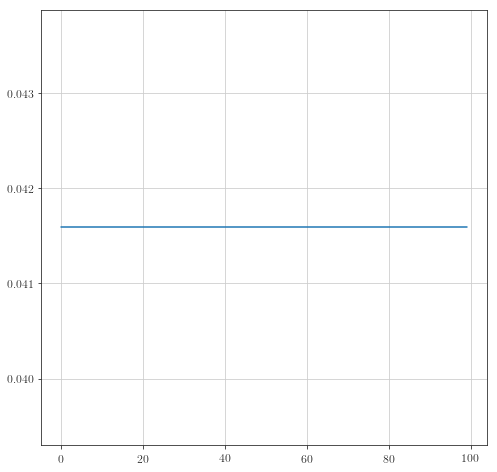

In [156]:
fig,ax=pl.subplots()
ax.plot(RR_shared_noise_store[0,::1000])
# ax.set_xlim(0,10000)

(0, 10000)

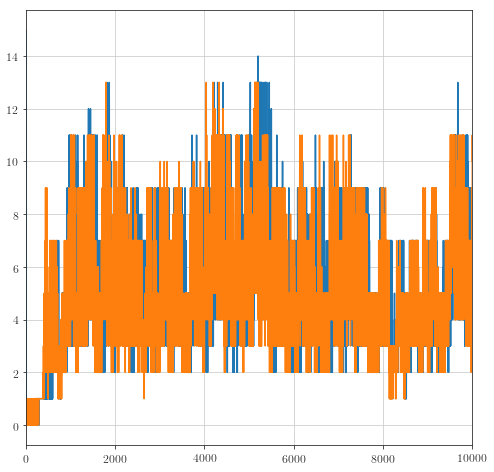

In [223]:
fig,ax=pl.subplots()
for it in range(2):
    ax.plot(t_decision_store[0,context_seq==it])
ax.set_xlim(0,10000)

In [64]:
rho_context_store[0,context_seq==0].mean()

0.038677181726961773

In [65]:
rho_context_store[0,context_seq==1].mean()

0.04699417145138171

In [66]:
len(rho_context_store[0,:])

100000

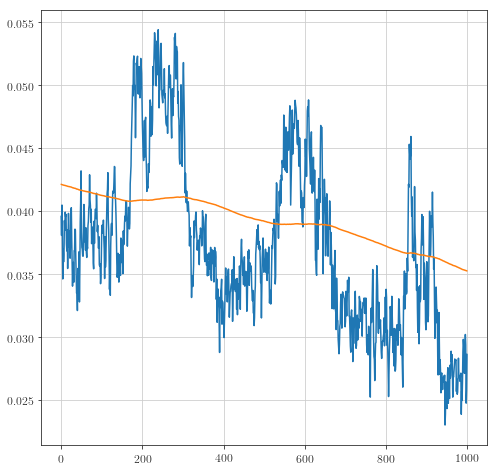

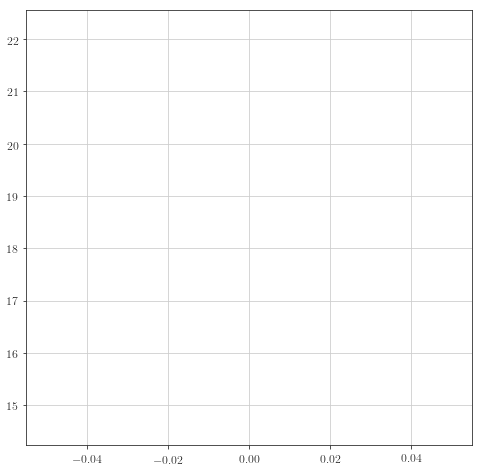

In [224]:
fig,ax=pl.subplots()
ax.plot(rho_context_store[:,99000:].T)
ax.plot(rho_long_store[:,99000:].T)
# ax.set_xlim(99000,100000)

fig,ax=pl.subplots()
ax.plot(T_context_store[:,99000:]);
# ax.set_xlim(99000,100000)


In [116]:
df_data_sim.head()

,seq,nChoiceMade,tDecision,nPostInterval,tauc
0,"[1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, ...",-1,15,150,1875.0
1,"[-1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1,...",1,0,150,1875.0
2,"[1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1...",-1,0,150,1875.0
3,"[1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -...",1,1,150,1875.0
4,"[1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -...",-1,0,150,1875.0


In [166]:
auto_corr

array([437856, 436710, 436727, ..., 436245, 436727, 436710])

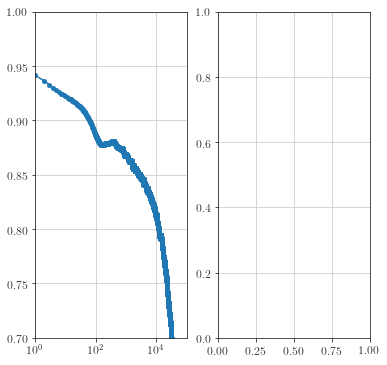

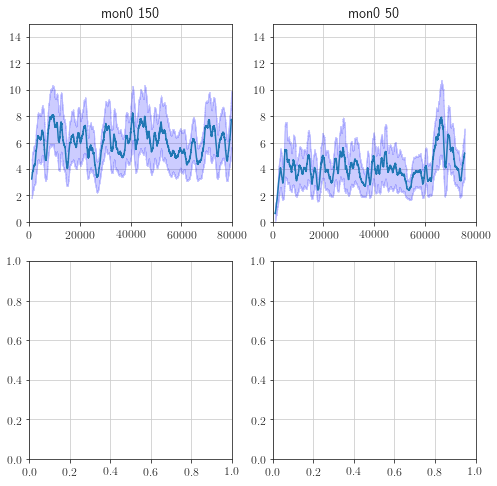

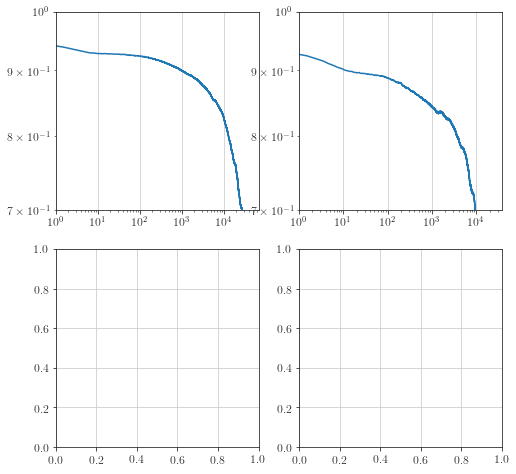

In [233]:
# win_size_vec=[1,500,1000,2000]
# for win_size in win_size_vec:
win_size=1000
NPOINTS=40454
color_res=int(NPOINTS/win_size)
COLOR='blue'
RESFACT=10
MAP='winter'
cm = pl.get_cmap(MAP)

# num_blocks=32
num_blocks=8

block_times=[150,50]
gamvec=[3/4,1/4]
fig3,ax3=pl.subplots(1,2,figsize=(6,6))
for i,tauc in enumerate(tau_contextvec):
    fig,ax=pl.subplots(2,2)
    fig2,ax2=pl.subplots(2,2)
    data_check=[]
    df_tmp=df_data_sim.loc[(df_data_sim.tauc==tauc)].reset_index()
    auto_corr=np.correlate(df_tmp.tDecision.values, df_tmp.tDecision.values, mode='same')
    ax3[i].plot(np.arange(-len(auto_corr)/2,len(auto_corr)/2),auto_corr/auto_corr[int(len(auto_corr)/2)],'.-')
#     ax3[i].set_xlim(1,1000)
    ax3[i].set_xlim(1,len(auto_corr)/2)
    ax3[i].set_xscale('log')
#     ax3[i].set_yscale('log')
    ax3[i].set_ylim(0.7,1)
    
    for j,post_interval in enumerate(block_times):
        df_tmp=df_data_sim.loc[((df_data_sim.tauc==tauc) & (df_data_sim.nPostInterval==post_interval))].reset_index()
#         df_tmp=df_data.loc[df_data.idSubject==i].reset_index()

        me=df_tmp.tDecision.rolling(window=win_size).mean()
        std=df_tmp.tDecision.rolling(window=win_size).std()
        maxval=df_tmp.tDecision.rolling(window=win_size).max()
        minval=df_tmp.tDecision.rolling(window=win_size).min()

        ax[i,j].fill_between(range(len(me)), me - std, me + std,color='b', alpha=0.2)
        df_tmp.tDecision.rolling(window=win_size).mean().plot.line(ax=ax[i,j])
        ax[i,j].set_ylim(0,para['T'])
        ax[i,j].set_xlim(0,80000)
        ax[i,j].set_title('mon'+str(i)+' '+str(post_interval))
        
        auto_corr=np.correlate(df_tmp.tDecision.values, df_tmp.tDecision.values, mode='same')
        ax2[i,j].plot(np.arange(-len(auto_corr)/2,len(auto_corr)/2),auto_corr/auto_corr[int(len(auto_corr)/2)])
        ax2[i,j].set_xlim(1,len(auto_corr)/2)
        ax2[i,j].set_xscale('log')
        ax2[i,j].set_yscale('log')
        ax2[i,j].set_ylim(0.7,1)
#         ax2.set_xscale('log')
#         df_tmp['reward']=(df_tmp.nChoiceMade==df_tmp.nCorrectChoice)
#         df_tmp['reward_rate']=df_tmp['reward']/(df_tmp.tDecision+df_tmp.nPostInterval/200*(T-df_tmp.tDecision)+7.5)

#         fig2,ax2=pl.subplots(1,2,figsize=(12,6))
#         df_tmp.reward.rolling(window=win_size).mean().plot.line(ax=ax2[0])
#         df_tmp.reward_rate.rolling(window=win_size).mean().plot.line(ax=ax2[1])
#         ax2[1].set_xlim(0,70000)
#         ax2[0].set_xlim(0,70000)
#         fig2.tight_layout()
#         fig2.suptitle(str(post_interval)+' '+str(i))

#         ax2[0].set_ylabel('Accuracy')
#         ax2[1].set_ylabel('Reward rate')
#         ax2[0].set_xlabel('Trial number')
#         ax2[1].set_xlabel('Trial number')
        

# #         data_check.append(df_tmp.reward_rate.rolling(window=win_size).mean().values)
#         data_check.append(df_tmp.groupby('block_ind').reward_rate.mean().rolling(window=num_blocks).mean().values)
        

# #     ax3.set_xlim(0,70000)
#     ax3.set_prop_cycle('color',[cm(1.*i/(len(data_check[1])-1)) for i in range(len(data_check[1])-1)])
# #     ax3.set_prop_cycle('color',[cm(1.*i/(color_res-1)) for i in range(color_res-1)])
#     x=data_check[0][:len(data_check[1])]
#     y=data_check[1]
# #     for i in range(color_res-5):
# #         ax3.plot(x[win_size*i:win_size*(i+1)],y[win_size*i:win_size*(i+1)])
# #         ax3.plot([x[win_size*i]],[y[win_size*i]],'ko')
# #         ax3.plot(x[color_res*i:color_res*(i+1)],y[color_res*i:color_res*(i+1)])
#     for i in range(len(data_check[1])):
#         ax3.plot(x[i:(i+2)],y[i:(i+2)],'.-')
    
# #     ax3.plot(data_check[0][:len(data_check[1])],data_check[1],'.')
#     fig3.suptitle(str(i))

#     ax3.set_ylabel('Reward rate slow')
#     ax3.set_xlabel('Reward rate fast')
# #         ax2[1].plot(ax2[1].get_xlim(),[(1/2)/(T/4+7.5)]*2,'k--')

map to state space

In [27]:
from scipy.interpolate import griddata
def plot_dec_times(df_data,pl,dataset_name,axbase,ax,ymax=None,T=15,start_time=None,itera=0):
    '''
    Computes empirical action policy distributions from a sample ensemble of trials held in the dataframe df_data 
    '''

    if (df_data.tDecision.values==0).sum():
        print('some decisions at t=0!')
        
    ###count distributions of decision events in (N_p,N_m) space 
    dec_counts=np.zeros((T+1,T+1))
    dec_R_counts=np.zeros((T+1,T+1))
    dec_L_counts=np.zeros((T+1,T+1))
    dec_wait_counts=np.zeros((T+1,T+1))
    for it,tdec in enumerate(df_data.tDecision.values):
        curr_traj=df_data.seq.iloc[it]
        #over all trajs 
        dec_counts[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm). int rounds down so should include current state. -1 to map to traj time index,
        #over trajs|action
        if df_data.nChoiceMade.iloc[it]==1:
            dec_R_counts[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm)
        else:# trial_dec[it]==-1:
            dec_L_counts[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm)
        for sit in range(1,int(tdec)): #add wait action up to decision
            dec_wait_counts[np.sum(curr_traj[:sit-1]==1),np.sum(curr_traj[:sit-1]==-1)]+=1 #increment occupancy at given (Np,Nm    
    #add t=0 data
    dec_counts[0,0]=(df_data.tDecision==0).sum()
    dec_R_counts[0,0]=((df_data.tDecision==0) & (df_data.nChoiceMade==1)).sum()
    dec_L_counts[0,0]=((df_data.tDecision==0) & (df_data.nChoiceMade==-1)).sum()
    dec_wait_counts[0,0]=len(df_data)-dec_R_counts[0,0]-dec_L_counts[0,0]
    
    
    mesh=np.meshgrid(range(T+1),range(T+1))
    Npvec=mesh[0].flatten()
    Nmvec=mesh[1].flatten()
    tvec=Npvec+Nmvec
    Nvec=Npvec-Nmvec
    for Np in range(T+1):
        for Nm in range(T+1):
            axbase.scatter(tvec.flatten(),Nvec.flatten(),s=160000*(dec_counts/np.sum(dec_counts)).flatten()**2,marker='+',linewidth=3)
    for Np in range(T+1):
        for Nm in range(T+1):
            if Np+Nm< T+1:
                axbase.scatter(Np+Nm,Np-Nm,s=5,facecolor='w',edgecolor='k',lw=0.5)
    axbase.set_xticks([0,1/3*T,2/3*T,T])
    axbase.set_yticks([-10,0,2/3*T])
    axbase.set_xlim([0,15])
    ###state occupancy count distributions in (N_p,N_m) space
    occupancy_counts=np.zeros((T+1,T+1))
    occupancy_predec_counts=np.zeros((T+1,T+1))
    surv_prob=np.zeros((T+1,T+1))
    Nt_samples=np.cumsum(np.asarray(df_data.seq.tolist()),axis=1) #note that this starts at t=1, so indexing adjusted by -1 below.
    tdec_vec=df_data.tDecision.apply(lambda x:int(x)).values
    for Np in np.arange(T+1):
        for Nm in np.arange(T+1):
            if Np+Nm<=T and Np+Nm>0:#=0
                occupancy_counts[Np,Nm]=np.sum(Nt_samples[:,Np+Nm-1]==Np-Nm)      
                occupancy_predec_counts[Np,Nm]=np.sum(Nt_samples[tdec_vec-1>=Np+Nm-1,Np+Nm-1]==Np-Nm) 
                surv_prob[Np,Nm]=np.sum(tdec_vec[Nt_samples[:,Np+Nm-1]==Np-Nm]>Np+Nm)/occupancy_counts[Np,Nm]
                                          
                #of ones that get here, what fraction have yet to decide
    surv_prob[0,0]=1  
    surv_prob[np.isnan(surv_prob)]=0
    occupancy_counts[0,0]=len(df_data) #all trajs go through (N_p=0,N_m=0).
    occupancy_predec_counts[0,0]=len(df_data)  #all trajs go through (N_p=0,N_m=0).
    
#     dec_dist=np.where(occupancy_predec_counts>0,dec_counts/occupancy_predec_counts,0)#*occupancy_counts/len(df_data)*10
    dec_dist=surv_prob#np.where(occupancy_predec_counts>0,dec_counts/occupancy_predec_counts,0)#*occupancy_counts/len(df_data)*10

    
    ###plot on smoothed coordinates.
    mesh=np.meshgrid(range(T+1),range(T+1))
    Npvec=mesh[0].flatten()
    Nmvec=mesh[1].flatten()
    tvec=Npvec+Nmvec
    Nvec=Npvec-Nmvec
    tvecdense=np.linspace(min(tvec),max(tvec),100)
    Nvecdense=np.linspace(min(Nvec),max(Nvec),100)
    #normalize dist for [0,1] colorscale
    z_d=griddata((tvec,Nvec),dec_dist.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
    
    point=8
    offset=0.5
    ax.fill_between(-offset+np.arange(point,2*point+1),-offset+point-np.arange(point+1),-offset+point+np.arange(point+1),color=[0.6,0.6,0.6],zorder=5)
    ax.fill_between(-offset+np.arange(point,2*point+1),offset-point-np.arange(point+1),offset-point+np.arange(point+1),color=[0.6,0.6,0.6],zorder=5)
    for Nm in 2*np.arange(T):
        ax.plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'ko',ms=0.5,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
    for Np in 2*np.arange(T):
        ax.plot(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2,'ko',ms=0.5,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
            
    #prob of deciding
    z_d[z_d<0]=0

    CS=ax.contourf(tvecdense,Nvecdense,z_d,30,cmap=pl.cm.twilight,vmax=1., vmin=0.)#,alpha=0.8)
    ax.contour(tvecdense,Nvecdense,z_d,levels=[0.5],linewidths=(1.,),colors=('w'),linestyles=('dotted'),zorder=15)

    ax.set_xlim(0,T)
    ax.set_ylim(-T,T)
    ax.set_xticks([0,1/3*T,2/3*T,T])

    point=8
    offset=0.5
    axbase.fill_between(-offset+np.arange(point,2*point+1),-offset+point-np.arange(point+1),-offset+point+np.arange(point+1),color=[0.6,0.6,0.6])
    axbase.fill_between(-offset+np.arange(point,2*point+1),offset-point-np.arange(point+1),offset-point+np.arange(point+1),color=[0.6,0.6,0.6])

    for Nm in 2*np.arange(T):
        axbase.plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
    for Np in 2*np.arange(T):
        axbase.plot(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
                
    return CS

In [ ]:
# df_data['Nt']=df_data.seq.apply(lambda x: np.insert(np.cumsum(x),0,0))

../lib/utils/ipynb_setup.py:92: RuntimeWarning: invalid value encountered in less


some decisions at t=0!


../lib/utils/ipynb_setup.py:92: RuntimeWarning: invalid value encountered in less


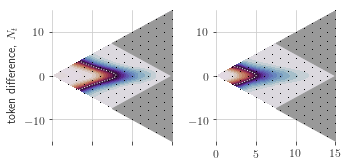

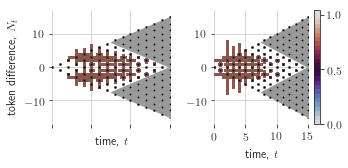

In [229]:
for tit in range(len(tau_contextvec)):
    block_times=[150,50]
    fig,ax=pl.subplots(1,2,figsize=(5,2.5)) #(10,5))#
    figbase,axbase=pl.subplots(1,2,figsize=(5,2.5))#(10,5))#
    # figamb,axamb=pl.subplots(1,2)
#     bias_store=np.zeros((2,2))

    for pit,post_interval in enumerate(block_times):
    #     dftmp=df_data[(df_data.idSubject==i) & (df_data.nPostInterval==post_interval)].reset_index()
        dftmp=df_data_sim[(df_data_sim.nPostInterval==post_interval) &(df_data_sim.tauc==tau_contextvec[tit])].reset_index()
        bias=plot_dec_times(dftmp,pl,'heuristic_post_'+str(post_interval),axbase[pit],ax[pit],pit)#,ymax=0.3)
    #         bias_store[pit,i-1]=bias
        axbase[pit].set_frame_on(False)
        ax[pit].set_frame_on(False)
    #         axbase[i-1,pit]=figb
    #         ax[i-1,pit]=fignorm
    #     xran=2 # limit of abs value of state
    #     amb_trajs_idx=dftmp['Nt'].apply(lambda x: not np.any(x>xran) and not np.any(x<-xran))

    #     dftmp[amb_trajs_idx]['tDecision'].hist(ax=axamb[pit],bins=np.arange(16),alpha=0.8)
    # ax[0,1].set_yticklabels([])
    # ax[1,1].set_yticklabels([])
    ax[0].set_xticklabels([])
    # ax[0,1].set_xticklabels([])
    # axbase[0,1].set_yticklabels([])
    # axbase[1,1].set_yticklabels([])
    # axbase[0,0].set_xticklabels([])
    axbase[0].set_xticklabels([])
    ax[0].set_ylabel('token difference, $N_t$')
    # ax[1,0].set_ylabel(r'token difference, $N_t$')
    # ax[1,0].set_xlabel(r'time, $t$')
    # ax[1].set_xlabel(r'time, $t$')
    axbase[0].set_ylabel('token difference, $N_t$')
    # axbase[1,0].set_ylabel(r'token difference, $N_t$')
    axbase[0].set_xlabel(r'time, $t$')
    axbase[1].set_xlabel(r'time, $t$')
    pl.colorbar(bias,ticks=[0, 0.5,1])
    fig.tight_layout()
    figbase.tight_layout()
    fig.savefig('heuristic_occu.pdf', transparent=True,bbox_inches="tight",dpi=300)
    figbase.savefig('heuristic_survprob.pdf', transparent=True,bbox_inches="tight",dpi=300)


some decisions at t=0!


../lib/utils/ipynb_setup.py:92: RuntimeWarning: invalid value encountered in less


some decisions at t=0!


../lib/utils/ipynb_setup.py:59: RuntimeWarning: invalid value encountered in true_divide
../lib/utils/ipynb_setup.py:92: RuntimeWarning: invalid value encountered in less


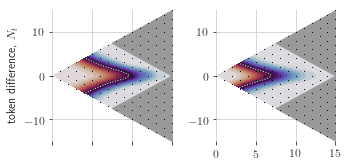

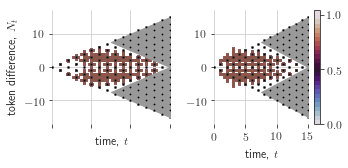

In [149]:
for tit in range(len(tau_contextvec)):
    block_times=[150,50]
    fig,ax=pl.subplots(1,2,figsize=(5,2.5))
    figbase,axbase=pl.subplots(1,2,figsize=(5,2.5))
    # figamb,axamb=pl.subplots(1,2)
#     bias_store=np.zeros((2,2))

    for pit,post_interval in enumerate(block_times):
    #     dftmp=df_data[(df_data.idSubject==i) & (df_data.nPostInterval==post_interval)].reset_index()
        dftmp=df_data_sim[(df_data_sim.nPostInterval==post_interval) &(df_data_sim.tauc==tau_contextvec[tit])].reset_index()
        bias=plot_dec_times(dftmp,pl,'heuristic_post_'+str(post_interval),axbase[pit],ax[pit],pit)#,ymax=0.3)
    #         bias_store[pit,i-1]=bias
        axbase[pit].set_frame_on(False)
        ax[pit].set_frame_on(False)
    #         axbase[i-1,pit]=figb
    #         ax[i-1,pit]=fignorm
    #     xran=2 # limit of abs value of state
    #     amb_trajs_idx=dftmp['Nt'].apply(lambda x: not np.any(x>xran) and not np.any(x<-xran))

    #     dftmp[amb_trajs_idx]['tDecision'].hist(ax=axamb[pit],bins=np.arange(16),alpha=0.8)
    # ax[0,1].set_yticklabels([])
    # ax[1,1].set_yticklabels([])
    ax[0].set_xticklabels([])
    # ax[0,1].set_xticklabels([])
    # axbase[0,1].set_yticklabels([])
    # axbase[1,1].set_yticklabels([])
    # axbase[0,0].set_xticklabels([])
    axbase[0].set_xticklabels([])
    ax[0].set_ylabel('token difference, $N_t$')
    # ax[1,0].set_ylabel(r'token difference, $N_t$')
    # ax[1,0].set_xlabel(r'time, $t$')
    # ax[1].set_xlabel(r'time, $t$')
    axbase[0].set_ylabel('token difference, $N_t$')
    # axbase[1,0].set_ylabel(r'token difference, $N_t$')
    axbase[0].set_xlabel(r'time, $t$')
    axbase[1].set_xlabel(r'time, $t$')
    pl.colorbar(bias,ticks=[0, 0.5,1])
    fig.tight_layout()
    figbase.tight_layout()
    # fig.savefig('heuristic_occu.pdf', transparent=True,bbox_inches="tight",dpi=300)
    # figbase.savefig('heuristic_survprob.pdf', transparent=True,bbox_inches="tight",dpi=300)


plot relaxation time between after block change

In [83]:
df_data_sim.nPostInterval.diff().unique()

array([  nan,    0., -100.,  100.])

In [89]:
tau_contextvec

array([ 92.5       , 113.05555556, 133.61111111, 154.16666667,
       174.72222222, 195.27777778, 215.83333333, 236.38888889,
       256.94444444, 277.5       ])

In [102]:
tau_contextvec

array([  9.375,  18.75 ,  37.5  ,  75.   , 150.   ])

500
499


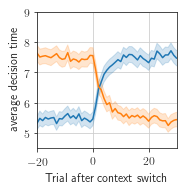

In [150]:
for tauc in tau_contextvec:
    df_tmp=df_data_sim[df_data_sim.tauc==tauc].copy().reset_index(drop=True)
    fig,ax=pl.subplots(figsize=(2.5,2.5))
#     block_ls=['-','-']


    df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff()

    #group transitions by fast-to-slow and slow-to-fast 
    time_depth=100
    history=20
    num_samples=((df_tmp.nPostInterval_diff.abs()>=time_depth) & (df_tmp.nPostInterval==50)).sum()
    print(num_samples)
    data_store_fast=np.zeros((num_samples,time_depth+history))
    for it,ind in enumerate(df_tmp[(df_tmp.nPostInterval_diff.abs()>=time_depth) & (df_tmp.nPostInterval==50)].index.values[:num_samples]):
        data_store_fast[it,:]=df_tmp.iloc[ind-history:ind+time_depth].tDecision.values
    
    num_samples=((df_tmp.nPostInterval_diff.abs()>=time_depth) & (df_tmp.nPostInterval==150)).sum()
    print(num_samples)
    data_store_slow=np.zeros((num_samples,time_depth+history))
    for it,ind in enumerate(df_tmp[(df_tmp.nPostInterval_diff.abs()>=time_depth) & (df_tmp.nPostInterval==150)].index.values[:num_samples]):
        data_store_slow[it,:]=df_tmp.iloc[ind-history:ind+time_depth].tDecision.values

    #raw data
    # fig,ax=pl.subplots(2,1,figsize=(4,8))
    # ax[0].plot(data_store_slow.T);
    # ax[0].plot(np.mean(data_store_slow.T,axis=1),'k',lw=5);
    # ax[1].plot(data_store_fast.T);
    # ax[1].plot(np.mean(data_store_fast.T,axis=1),'k',lw=5);#,color=p[-1].get_color());
    # ax[0].set_xlim(0,30)
    # ax[1].set_xlim(0,30)

    #mean &sem
    sv_vec=['slow','fast']
    for pit,data in enumerate((data_store_slow,data_store_fast)):
        me=np.mean(data,axis=0)
        np.save('data_tau_'+sv_vec[pit]+'_'+str(int(tauc))+'.npy',me)
        sem=np.std(data,axis=0)/np.sqrt(data.shape[1])
        p=ax.plot(np.arange(-history,time_depth),me,color='C'+str(pit));
        ax.fill_between(np.arange(-history,time_depth), me - sem, me + sem, color='C'+str(pit),alpha=0.2)
    ax.set_xlabel('Trial after context switch')
    ax.set_ylabel('average decision time')
    ax.set_ylim(4.5,9)
    ax.set_xlim(-20,30)
#     ax.legend(frameon=False,ncol=3,bbox_to_anchor=(1,1.2))
#     fig.savefig('heuristic_transitions.pdf', transparent=True,bbox_inches="tight",dpi=300)


../lib/utils/ipynb_setup.py:31: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0


AttributeError: 'DataFrame' object has no attribute 'nCorrectChoice'

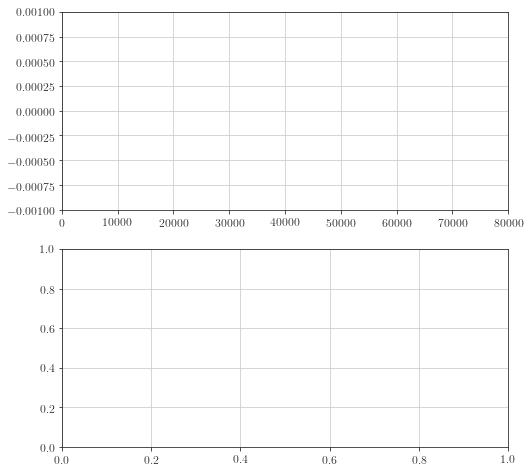

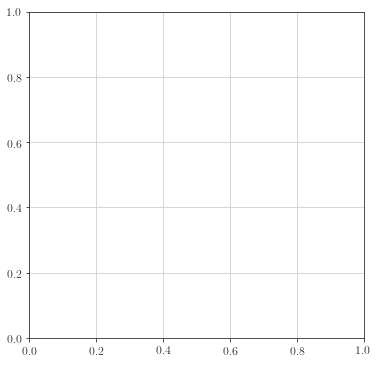

In [310]:
# win_size_vec=[1,500,1000,2000]
# for win_size in win_size_vec:
win_size=1000
NPOINTS=40454
color_res=int(NPOINTS/win_size)
COLOR='blue'
RESFACT=10
MAP='winter'
cm = pl.get_cmap(MAP)

# num_blocks=32
num_blocks=8

block_times=[150,50]
gamvec=[3/4,1/4]
fig,ax=pl.subplots(2,1)
# for i in range(1,3):
data_check=[]
fig3,ax3=pl.subplots(1,1,figsize=(6,6))
for j,post_interval in enumerate(block_times):
    df_tmp=df_data_sim.loc[df_data_sim.nPostInterval==post_interval].reset_index()
#         df_tmp=df_data.loc[df_data.idSubject==i].reset_index()

    me=df_tmp.tDecision.rolling(window=win_size).mean()
    std=df_tmp.tDecision.rolling(window=win_size).std()
    maxval=df_tmp.tDecision.rolling(window=win_size).max()
    minval=df_tmp.tDecision.rolling(window=win_size).min()

    ax[j].fill_between(range(len(me)), me - std, me + std,color='b', alpha=0.2)
    df_tmp.tDecision.rolling(window=win_size).mean().plot.line(ax=ax[j])
    ax[j].set_ylim(0,T)
    ax[j].set_xlim(0,80000)

    df_tmp['reward']=(df_tmp.nChoiceMade==df_tmp.nCorrectChoice)
    df_tmp['reward_rate']=df_tmp['reward']/(df_tmp.tDecision+df_tmp.nPostInterval/200*(T-df_tmp.tDecision)+7.5)

    fig2,ax2=pl.subplots(1,2,figsize=(12,6))
    df_tmp.reward.rolling(window=win_size).mean().plot.line(ax=ax2[0])
    df_tmp.reward_rate.rolling(window=win_size).mean().plot.line(ax=ax2[1])
    ax2[1].set_xlim(0,70000)
    ax2[0].set_xlim(0,70000)
    fig2.tight_layout()
    fig2.suptitle(str(post_interval)+' '+str(i))

    ax2[0].set_ylabel('Accuracy')
    ax2[1].set_ylabel('Reward rate')
    ax2[0].set_xlabel('Trial number')
    ax2[1].set_xlabel('Trial number')


#         data_check.append(df_tmp.reward_rate.rolling(window=win_size).mean().values)
    data_check.append(df_tmp.groupby('block_ind').reward_rate.mean().rolling(window=num_blocks).mean().values)


#     ax3.set_xlim(0,70000)
ax3.set_prop_cycle('color',[cm(1.*i/(len(data_check[1])-1)) for i in range(len(data_check[1])-1)])
#     ax3.set_prop_cycle('color',[cm(1.*i/(color_res-1)) for i in range(color_res-1)])
x=data_check[0][:len(data_check[1])]
y=data_check[1]
#     for i in range(color_res-5):
#         ax3.plot(x[win_size*i:win_size*(i+1)],y[win_size*i:win_size*(i+1)])
#         ax3.plot([x[win_size*i]],[y[win_size*i]],'ko')
#         ax3.plot(x[color_res*i:color_res*(i+1)],y[color_res*i:color_res*(i+1)])
for i in range(len(data_check[1])):
    ax3.plot(x[i:(i+2)],y[i:(i+2)],'.-')

#     ax3.plot(data_check[0][:len(data_check[1])],data_check[1],'.')
fig3.suptitle(str(i))

ax3.set_ylabel('Reward rate slow')
ax3.set_xlabel('Reward rate fast')
#         ax2[1].plot(ax2[1].get_xlim(),[(1/2)/(T/4+7.5)]*2,'k--')